In [1]:
import json
routes = json.loads(open('/home/student/db/resources/trimmed_routes.json','r').read())
from dbanalysis import stop_tools


## All stop segments in a route together

In [2]:
r=routes['15'][1][1:]

In [3]:

to_concat = []
for i in range(0,len(r)-1):
    d = stop_tools.stop_data(str(r[i]),str(r[i+1]))
    ok_routes = [i for i in d['routeid'].unique() if i[0:2]=='15']
    to_concat.append(d[d['routeid'].isin(ok_routes)])
    del(d)


In [4]:
import pandas as pd
df = pd.concat(to_concat)
del(to_concat)

In [8]:
len(df)

1610704

In [9]:
import seaborn as sns

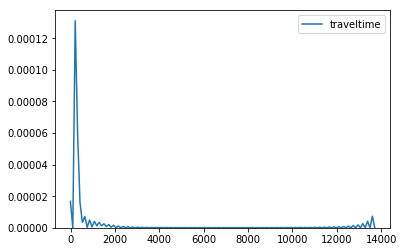

In [10]:
sns.kdeplot(df['traveltime'])

#### There are a small number of extreme outliers. They get dropped when building the final models

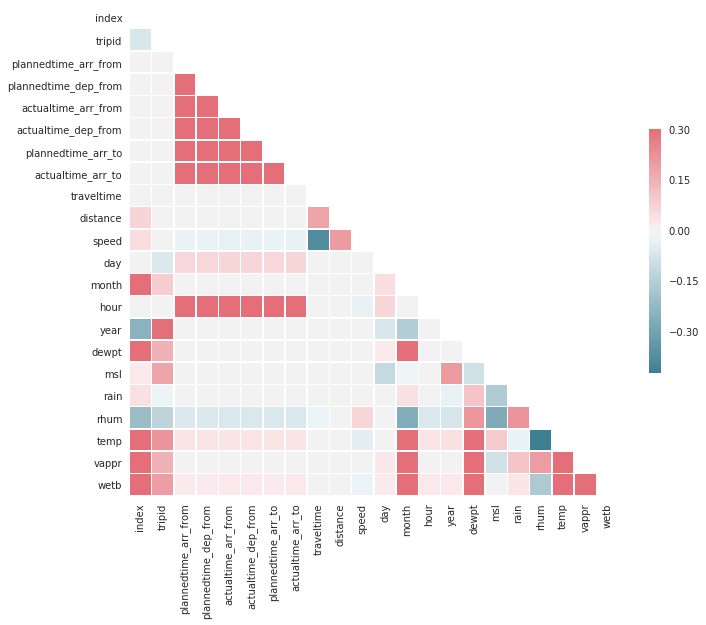

In [8]:
#correlation matrix code is from online tutorial
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
#rs = np.random.RandomState(33)


# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [24]:
import seaborn as sns

## Plotting day, month, and week with traveltime

In [8]:
means = []
hours = []
for hour in sorted(df['hour'].unique()):
    means.append(df[df['hour']==hour]['traveltime'].mean())
    hours.append(hour)
    


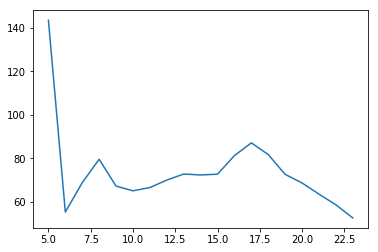

In [9]:
from matplotlib import pyplot as plt
plt.plot(hours,means)

### The high value at the beginning is assumed to be because only the first fews stops have values for this time

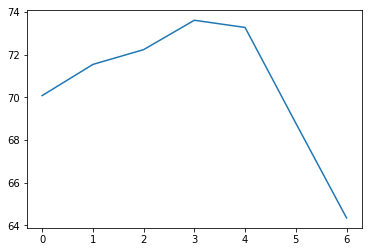

In [11]:
means = []
days = []
for day in sorted(df['day'].unique()):
    means.append(df[df['day']==day]['traveltime'].mean())
    days.append(day)
    
from matplotlib import pyplot as plt
plt.plot(days,means)

In [14]:
df['month'].unique()

array([1, 2, 3, 4, 5, 6])

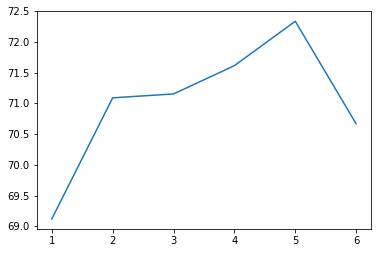

In [15]:
means = []
months = []
for month in sorted(df['month'].unique()):
    means.append(df[df['month']==month]['traveltime'].mean())
    months.append(month)
    
from matplotlib import pyplot as plt
plt.plot(months,means)

From these graphs we can that the mean does indeed vary significantly by month

In [16]:
len(df[df['year']==2016])

971613

In [17]:
len(df[df['year']==2017])

639091

There is significantly more data for 2016 than for 2017

In [19]:
df['dwelltime'] = df['actualtime_dep_from'] - df['actualtime_arr_from']

In [21]:
len(df[df['dwelltime']==0])

601664

In [22]:
len(df[df['dwelltime']!=0])

1009040

Dwell time is 0 for a very large portion of the dataframe.

## All stops in a route with distance and travel time from the first stop

In [11]:
from dbanalysis import stop_tools
import pandas as pd
class BRModel():
    """
    Big route model class
    uses the distance of a stop from first stop on a route to compute predictions lalalala
    MAPE and r2 scores are not as good as they were in the notebook
    (we achieved 0.57 r2, and 7% MAPE on the time to complete the route)
    Should look into this.
    """
    def __init__ (self, route,variation,verbose=True,src='build',rgr='RandomForest',\
                mode='validate',features = ['base_time_dep','distance','rain','temp','day'],use_dummies=True):
        
        import json
        self.regr_type = rgr
        self.verbose = verbose
        self.route = route
        self.use_dummies = use_dummies
        self.variation = variation
        self.routes = json.loads(open('/home/student/dbanalysis/dbanalysis/resources/trimmed_routes.json').read())
        self.features = features
        self.route_array = self.routes[route][variation][1:]
        del(self.routes)
        if src == 'build':
            if not self.can_be_modelled():
                print('fuck')
                raise ValueError ('Missing data for modelling this route')

            self.gather_data()
            self.preprocess()
            if rgr == 'RandomForest':
                from sklearn.ensemble import RandomForestRegressor as rf
                self.rgr = rf()
            elif rgr == 'Linear':
                from sklearn.linear_model import LinearRegression as lr
                self.rgr = lr(fit_intercept=True)
            elif rgr == 'Neural':
                from sklearn.neural_network import MLPRegressor as mlpr
                self.rgr = mlpr(hidden_layer_sizes=(100,100),verbose=True)
                from sklearn.preprocessing import normalize
                
 
            #if mode == 'validate':
            #   if self.regr_type == 'Neural':
                    #self.validate_neural()
            #   else:
                    #self.validate_model()
            #lif mode == 'production':
                #self.build_full_model()
                #self.dump_model()
    def validate_neural(self):
        print('training regressor')
        self.model = self.rgr.fit(self.train_X,self.train_Y)
        preds = self.model.predict(self.test_1_X)
        from sklearn import metrics
        print('Validating...')
        print(metrics.r2_score(self.test_1_Y,preds))
        preds = self.model.predict(self.test_2_X)
        print(metrics.r2_score(self.test_2_Y,preds))
        print('calculated from norms-->')
        preds = preds * self.test_2_norm
        print(metrics.r2_score(self.test_2_real,preds))
        preds = self.model.predict(self.test_3_X)
        print(metrics.r2_score(self.test_3_Y,preds))
    def validate_model(self):
        self.data = self.data[self.data['traveltime']>0] 
        if self.verbose:
            print('Validating model on all trips...\n\n')
        
        self.train = self.data[self.data['year']==2016]
        self.test = self.data[self.data['year']==2017]
        self.model = self.rgr.fit(self.train_X,self.train_Y)
        preds = self.model.predict(self.test_1_X)
        from sklearn import metrics
        print('-----> Tested on all distances')
        print('R2:', metrics.r2_score(self.test_1_Y,preds))
        print('MAE:', metrics.mean_absolute_error(self.test_1_Y,preds)*self.norm[-1])
        print('MAPE:', ((abs(self.test_1_Y-preds)/self.test_1_Y)*100).mean())
        #add more options for testing eventually
        print('Validating model on longest trip')
        test2= self.test[self.test['distance']==self.test['distance'].max()]
        if self.regr_type == 'Neural':
            test2 = self.test[self.test['distance2']==self.test['distance2'].max()]
        preds = self.model.predict(test2[self.features])
        print('-----> ')
        print('R2:', metrics.r2_score(test2['traveltime'],preds))
        print('MAE:', metrics.mean_absolute_error(test2['traveltime'],preds)*self.norm[-1])
        print('MAPE:', ((abs(test2['traveltime']-preds)/test2['traveltime'])*100).mean())
        print('\n\n Validated on median trip -->')
        test2= self.test[self.test['distance']==self.test['distance'].median()]
        if self.regr_type == 'Neural':
            test2 = self.test[self.test['distance2']==self.test['distance2'].median()]
        
        preds = self.model.predict(test2[self.features])
        print('-----> ')
        print('R2:', metrics.r2_score(test2['traveltime'],preds))
        print('MAE:', metrics.mean_absolute_error(test2['traveltime'],preds)*self.norm[-1])
        print('MAPE:', ((abs(test2['traveltime']-preds)/test2['traveltime'])*100).mean())
        del(self.train)
        del(self.test)
        del(self.data)
        del(test2)


    def gather_data(self):
        if self.verbose:
            print('gathering data...')
        from dbanalysis import stop_tools
        arr = self.route_array
        import os
        to_concat = []
        for i in range(len(arr)-1):
            
            data = stop_tools.get_stop_link(arr[i],arr[i+1])
            to_concat.append(data)
            del(data)
        self.data = pd.concat(to_concat,axis=0)
        del to_concat
        

    def preprocess(self):
        if self.verbose:
            print('Preprocessing data')
        self.select_routes()
        self.clean_1()
        self.add_distances()
        self.add_base_departure_time()
        self.add_time_info()
        
        self.merge_weather()
        #if self.use_dummies:
        #    self.add_dummies()
        #    self.features += self.dummy_features
    def select_routes(self):
        if self.verbose:
            print('parsing routeids')
        routeids = self.data['routeid'].unique()
        valid_routeids = [r for r in routeids if r.split('_')[0] == self.route]
        self.data = self.data[self.data['routeid'].isin(valid_routeids)]
    def clean_1(self):
        if self.verbose:
            print('dropping null values')
        self.data = self.data.dropna()
        
    def add_distances(self):
        if self.verbose:
            print('adding distances')
        s_getter =stop_tools.stop_getter()
        total_distance = 0
        r = self.route_array
        route_distances = {r[0]:0}
        
        for i in range(0, len(r)-1):
            distance = s_getter.get_stop_distance(str(r[i]),str(r[i+1]))
                
            total_distance += distance
            route_distances[r[i+1]]=total_distance
        self.data['distance']=self.data['stopA'].apply(lambda x: route_distances[x])
        del(s_getter)
    def add_base_departure_time(self):
        if self.verbose:
            print('adding base departure times')
       
        keys= self.data[self.data['stopA']==self.route_array[0]]
        keys['base_time_dep']=keys['actualtime_arr_from']
        keys2=keys[['tripid','dayofservice','routeid','base_time_dep']]
        self.data = pd.merge(self.data,keys2,on=['dayofservice','tripid','routeid'])
        
        self.data['traveltime']=self.data['actualtime_arr_from']-self.data['base_time_dep'] 
        #A number of rows have negative travel time. But its a really small number, so I guess they 
        #can go in the bin.
        self.data = self.data[self.data['traveltime']>0]
        del(keys)
        del(keys2)
    
    def add_time_info(self):
        if self.verbose:
            print('adding time information')
        time_format = "%d-%b-%y %H:%M:%S"
        self.data['dt']=pd.to_datetime(self.data['dayofservice'],format=time_format)
        self.data['day']=self.data['dt'].dt.dayofweek
        self.data['month']=self.data['dt'].dt.month
        self.data['hour'] = self.data['dt'].dt.hour
        self.data['weekend']=self.data['day']>4
        self.data['year']=self.data['dt'].dt.year
        self.data['date'] = self.data['dt'].dt.date
    def merge_weather(self,weather=None):
        if self.verbose:
            print('merging weather')
        if weather == None:
          
            weather = pd.read_csv('/home/student/dbanalysis/dbanalysis/resources/cleanweather.csv').dropna()
        weather['dt']=pd.to_datetime(weather['date'])
        weather['hour']=weather['dt'].dt.hour
        weather['date']=weather['dt'].dt.date
        
        self.data = pd.merge(self.data,weather,on=['date','hour'])
        del(weather)

    def add_dummies(self):
        if self.verbose:
            print('Making dummy features')
        self.data = pd.get_dummies(self.data,columns=['day','month','hour'])
        self.dummy_features = [col for col in self.data.columns\
                                if (col[0:3] == 'day' and col != 'dayofservice')\
                                or col[0:5] == 'month' or col[0:4] == 'hour']


    def can_be_modelled(self):
        if self.verbose:
            print('Checking for data files')
        import os
        base_dir = '/data/stops/'
        arr = self.route_array
        for i in range(len(arr)-1):
            
            if os.path.exists(base_dir+str(arr[i])+'/'+str(arr[i+1])+'.csv'):
                pass
            else:
                print('broken')
                input()
                return False
        return True


In [12]:
r = BRModel('15',1,rgr='Neural')


Checking for data files
gathering data...
Preprocessing data
parsing routeids
dropping null values
adding distances
adding base departure times


/home/student/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


adding time information
merging weather


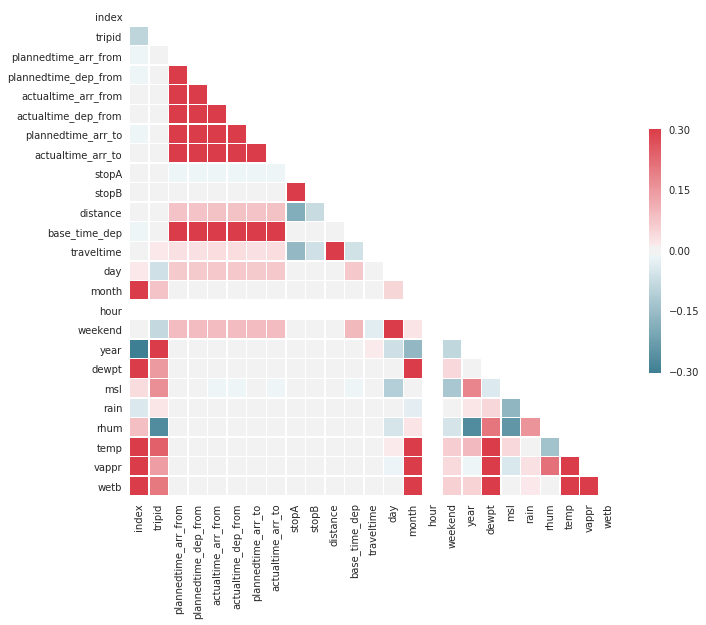

In [13]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
#rs = np.random.RandomState(33)


# Compute the correlation matrix
corr = r.data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# It isn't surprising that, when tested like this, nothing will particularly correlate with travel time either.

# Looking at just the travel time to complete the whole of the route

In [15]:
del(r)

In [16]:
def get_merged(stop):
    route = routes['15'][1][1:]
    begins = stop_tools.stop_data(str(route[0]),str(route[1]))
    begins = begins[begins['year']==2017]
    ends = stop_tools.stop_data(str(route[int(stop)]),str(route[int(stop)+1]))
    ends = ends[ends['year']==2017]
    ends['end'] = ends['actualtime_arr_to']
    
    merged = pd.merge(begins,ends[['tripid','dayofservice','routeid','end']], on=['tripid','dayofservice','routeid'])
    merged = merged[merged['traveltime']>0]
    return merged

In [18]:
df = get_merged(68)

In [21]:
df['traveltime'] = df['end'] - df['actualtime_arr_from']

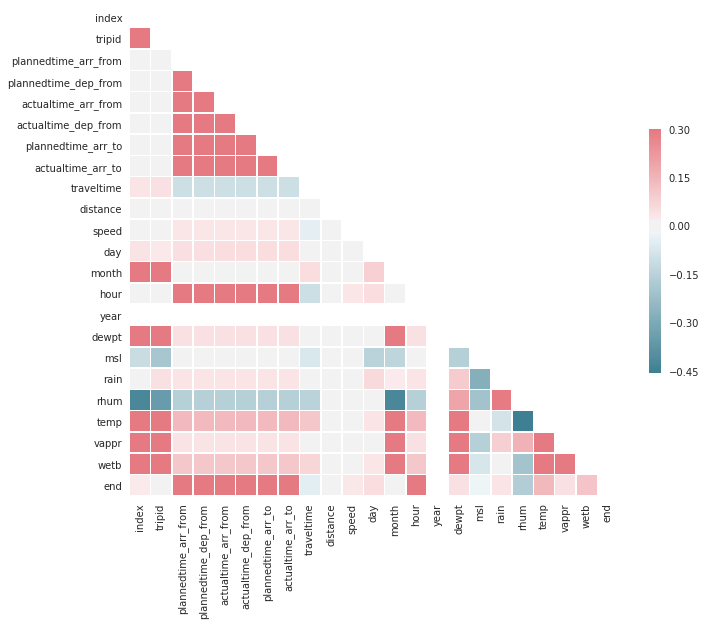

In [22]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
#rs = np.random.RandomState(33)


# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Taken like this, traveltime for the entirety of the route correlates with temperature, wetb, rhum, hour, month

The correlations between weather and hour are a bit strange, but probably make sense if you take account of things like dew in the mornings, 
and different temperatures over the course of the day. The small correlation with rain must be accidental

In [23]:
del(df)